## VA and Center for Medicaid Services (CMS) Use Case
## Proposed Walkthrough/"Solution"
#### Written: 9/12/2020
#### Updated: 10/7/2020

### Introduction
The below document includes code and descriptive text evaluating the use case assessment *title here*. Full materials for this use case can be found on the [Python OER GitHub Repository](https://github.com/domdisanto/Python_OER/tree/master/Use%20Cases/VA%20Dual%20Enrollment%20Case). This walkthrough document is tentatively titled a "solution" as, while this document offers a specific way of cleaning and analyzing the available, this document certainly does not offer a unique (or even a uniquely-best) solution to the given assessment. 

The writing in this document will do its best to outline specific parameters that should be met to satisfactorically complete the assessment. These parameters, tasks, outputs, etc. exist solely to assess your developing skills as an analyst and Python programmer. That being said, if you take different steps or follow a different analytic method to reach the same results, that is perfectly acceptable! This walk through is intended only to be *a* demonstrated workflow, but it is possible (and even likely) that you may write more efficient, simpler, or more scalable code than what is included here that achieves the same results! 

### (1) Import CMS and VA data into your Jupyter Notebook

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
va_data = pd.read_csv('VA_data.csv')
cms_data = pd.read_csv('CMS_data.csv')

In [3]:
va_data.sample(5)

,Patient ID,Visit Date,Age,Height,Weight,Medication,Medication Dose,Medication Dose Unit,Medication Duration Value,Medication Duration Unit
741,669010219,2018-09-29,43.0,155.62,63.98,tramadol HCL,200.0,mg,42,Day
433,680617309,2018-07-09,74.0,166.13,97.25,gabapentin,1200000.0,mcg,49,Day
28,923577376,2018-04-03,63.0,163.67,92.41,buprenorphine,0.3,mg,48,Day
37,297976105,2018-08-30,80.0,161.66,72.42,gabapentin,600.0,mg,2,Week
715,693925710,2019-08-04,45.0,182.40,107.76,gabapentin,600.0,mg,40,Day


In [4]:
cms_data.sample(5)

,Patient ID,Medication,Medication Dose Unit,Medication Dose,Medication Duration,Duration Unit,Visit Date
368,188-48-3541,BUPRENORPHINE TABLET,mg,1.8,35,Day,2019-12-09
199,952-77-0365,IBUPROFEN,mg,600.0,2,Week,2018-08-20
70,625-09-2531,DIHYDROCODEINE,mcg,90000.0,5,Week,2019-10-19
30,450-17-9156,IBUPROFEN,mg,300.0,57,Day,2018-06-29
91,440-61-0968,IBUPROFEN,mg,600.0,5,Week,2019-04-27


### (2) Create opioid administration outcome variable of interest within both the VA and CMS data

From our preview above (the two calls of .head() to our data frames), we notice some differences in the medication syntax (or the details of the text input for each character/string variable). I will first examine and clean the Medication variables, such that medications are consistently "coded" between the VA and CMS data. I will then use this single, standardized list of medication values to create the binary opioid administration variable. 

A note, you do not *have* to do this cleaning during this step. You could simply examine the data frames, categorize opioid use separately using their respective medication values. 

Below, we simply examine the medications present in each data frame: 

In [5]:
print('The CMS data set contains the following medications: \n', set(cms_data['Medication']),
      "\n \n",
      'The VA data set contains the following medications: \n', set(va_data['Medication']))

The CMS data set contains the following medications: 
 {'BUPRENORPHINE', 'DIHYDROCODEINE', 'TRAMADOL', 'GABAPENTIN', 'BUTORPHANOL', 'IBUPROFEN', 'BUPERNORPHINE', 'BUPRENORPHINE TABLET'} 
 
 The VA data set contains the following medications: 
 {'tramadol HCL', 'dihydrocodeine', 'tramadol', 'gabapentin', 'butorphanol', 'acetaminophen', 'dihydrocodeine-acetaminophin-caff', 'buprenorphine', 'ibuprofen'}


We can first notice medication variable are stored using different text-case between the two data-frames (i.e. `BUPERNORPHINE`$\neq$`bupernorphine` as far as Python knows). We can choose to either standardize the medications between our two data frames or simply to work with the medication data "as-is". 

#### Solution 1 - Working with the Data "As-Is"

For purposes of this assignment, we do not need any medication specific data, so it may be simpler to simply work with the medication data as-is. We must then simply identify opioids (or in general, the medications/values for our variables that we want to "tag"/identify) and then use this list to create an indicator or dummy variable. I will code this variable as "1" if the given patient is given an opioid or a "0" othewrise.

In [6]:
# Creating a list of opioids
op_mds = ['BUPERNORPHINE', 'BUPRENORPHINE', 'BUPRENORPHINE TABLET', 'BUTORPHANOL', 'DIHYDROCODEINE',
          'TRAMADOL', 'buprenorphine', 'butorphanol', 'dihydrocodeine', 'tramadol', 'tramadol HCL'
         'dihydrocodeine-acetaminophen-caff']

cms_data['Opioid'] = cms_data['Medication'].isin(op_mds).astype('int')
va_data['Opioid'] = va_data['Medication'].isin(op_mds).astype('int')

# Printing out some data to check our results
cms_data[['Patient ID', 'Medication', 'Opioid']].sample(10)

,Patient ID,Medication,Opioid
153,540-89-3070,TRAMADOL,1
144,715-54-9194,BUPRENORPHINE,1
266,705-66-2505,GABAPENTIN,0
297,971-21-8779,GABAPENTIN,0
96,297-20-9817,IBUPROFEN,0
178,465-56-4532,BUPRENORPHINE,1
312,250-69-8144,BUPRENORPHINE TABLET,1
221,469-81-1345,IBUPROFEN,0
344,359-19-4604,GABAPENTIN,0
272,427-69-7789,BUPRENORPHINE,1


In [7]:
va_data[['Patient ID', 'Medication', 'Opioid']].sample(10)

,Patient ID,Medication,Opioid
412,538210362,gabapentin,0
325,937930050,gabapentin,0
20,549807126,gabapentin,0
346,377254491,tramadol HCL,0
439,921503084,gabapentin,0
206,413693192,gabapentin,0
529,915622794,tramadol HCL,0
140,666768372,gabapentin,0
114,906512385,dihydrocodeine-acetaminophin-caff,0
193,166225404,tramadol,1


Althrough not a necessary step in this solution, it may be useful in other instances to standardize the values between our two data frames prior to creating an indicator value, as shown below.    
  
We see similar medications are contained in both data frames with different letter case used, somewhat different nomenclature for `tramadol` (also referenced as `tramadol HCL`) and `buprenorphine` (`BUPRENORPHINE TABLET` in the CMS data), a mispelled `bupernorphine` in the CMS data set, and references to `dihydrocodeine` as `dihydrocodeine-acetaminophin-caff`.   
   
There are a few solutions, all of which require "telling" Python the correct syntax we would like to use, and replacing the values in one or both of our data frames with these corrected or standardized values. Below I present an example using lists and a preferable solution using dictionaries:

In [8]:
# We can create and cycle through a pair of lists 

va_demo = va_data 
    # Creating demo data set to not save results to our actual `va_data` data frame

current_meds = ['BUPERNORPHINE', 'BUPRENORPHINE', 'BUPRENORPHINE TABLET', 'DIHYDROCODEINE', 
               'GABAPENTIN', 'IBUPROFEN','TRAMADOL', 'BUTORPHANOL', 'acetaminophen',  
               'buprenorphine', 'butorphanol', 'dihydrocodeine', 'dihydrocodeine-acetaminophin-caff',
               'gabapentin', 'ibuprofen', 'tramadol', 'tramadol HCL']
    # List of current, "incorrect" meds 
    
new_meds = ['buprenorphine', 'buprenorphine', 'buprenorphine', 'dihydrocodeine', 
              'gabapentin','ibuprofen', 'tramadol', 'butorphanol', 'acetaminophen',
              'buprenorphine', 'butorphanol', 'dihydrocodeine', 
              'dihydrocodeine', 'gabapentin', 'ibuprofen', 'tramadol', 'tramadol']
    # list of corrected medications
    # this list must be 1:1 with the current_meds as a sort of pseudo dictionary
    


for i in range(0, len(new_meds)):
            va_demo = va_demo.replace(current_meds[i], new_meds[i])

           
# The below code is demonstrating the applied fix, and is NOT necessary/used in this step's solution 
pd.merge(va_demo.loc[va_demo['Medication']=='tramadol',
                                  ['Patient ID', 'Medication']],
         va_data.loc[va_data['Medication']=='tramadol HCL',
                                  ['Patient ID', 'Medication']],
         on='Patient ID', 
         suffixes=['_fix', '_original'] ).head()
 # Outputting a quick merge test to demonstrate the change in medications
 

,Patient ID,Medication_fix,Medication_original
0,609548877,tramadol,tramadol HCL
1,388838303,tramadol,tramadol HCL
2,500439782,tramadol,tramadol HCL
3,122196611,tramadol,tramadol HCL
4,355559822,tramadol,tramadol HCL


In contrast to the list code above, we can somewhat more neatly use a dictionary, as demonstrated and used below. 
     
  
Recall that in a dictionary, each "*key*" (in this instance the original medication values) requires a corresponding "*value*". Therefore every incorrect medication was pass into a dictionary has a corresponding correction. We do not have to worry that our two lists from the above chunk are the same length, and we can more easily verify that we have correctly paired our original medication text to the correction (or our *key* to its corresponding *value*). 
     

In [9]:
meds_dict =  {'BUPERNORPHINE': 'buprenorphine', 'BUPRENORPHINE': 'buprenorphine',
              'BUPRENORPHINE TABLET': 'buprenorphine', 'DIHYDROCODEINE': 'dihydrocodeine', 
              'GABAPENTIN': 'gabapentin','IBUPROFEN': 'ibuprofen','TRAMADOL': 'tramadol',
              'BUTORPHANOL': 'butorphanol', 'acetaminophen': 'acetaminophen', 
              'buprenorphine': 'buprenorphine', 'butorphanol': 'butorphanol',
              'dihydrocodeine': 'dihydrocodeine', 
              'dihydrocodeine-acetaminophin-caff': 'dihydrocodeine', 'gabapentin': 'gabapentin',
              'ibuprofen': 'ibuprofen', 'tramadol': 'tramadol', 'tramadol HCL': 'tramadol'}


cms_data['Medication'] = cms_data['Medication'].map(meds_dict).fillna(cms_data['Medication'])
cms_data.sample(10)



,Patient ID,Medication,Medication Dose Unit,Medication Dose,Medication Duration,Duration Unit,Visit Date,Opioid
176,404-71-1585,tramadol,mg,1200.0,1,Month,2018-06-04,1
376,969-82-6843,gabapentin,mcg,900000.0,48,Day,2019-03-26,0
107,512-75-6600,gabapentin,mg,900.0,4,Week,2019-04-13,0
213,179-87-8983,gabapentin,mg,900.0,58,Day,2019-10-31,0
27,287-87-4276,buprenorphine,mg,1.8,29,Day,2018-02-09,1
310,691-92-3372,tramadol,mg,600.0,3,Week,2018-10-19,1
141,988-63-9293,ibuprofen,mg,1200.0,33,Day,2018-03-05,0
42,173-70-3297,tramadol,mg,1200.0,5,Week,2019-04-03,1
126,588-80-6682,ibuprofen,mcg,1200000.0,2,Week,2019-04-10,0
237,642-96-6458,tramadol,mg,300.0,47,Day,2019-03-25,1


In [10]:
va_data['Medication'] = va_data['Medication'].map(meds_dict).fillna(va_data['Medication'])
va_data

,Patient ID,Visit Date,Age,Height,Weight,Medication,Medication Dose,Medication Dose Unit,Medication Duration Value,Medication Duration Unit,Opioid
0,609548877,2018-06-19,76.0,177.61,98.53,tramadol,400000.0,mcg,58,Day,0
1,224736371,2019-09-29,76.0,170.71,87.60,ibuprofen,400.0,mg,29,Day,0
2,601083249,2018-10-02,76.0,188.42,107.11,gabapentin,1200000.0,mcg,42,Day,0
3,233862042,2018-07-18,80.0,168.50,90.58,butorphanol,5000.0,mcg,57,Day,1
4,485487112,2018-10-09,57.0,175.80,93.96,gabapentin,600.0,mg,30,Day,0
...,...,...,...,...,...,...,...,...,...,...,...
803,975180104,2018-02-13,35.0,169.84,84.09,acetaminophen,800.0,mg,34,Day,0
804,454394346,2018-07-02,42.0,181.29,106.32,ibuprofen,200000.0,mcg,31,Day,0
805,233499695,2018-11-05,40.0,169.51,73.74,ibuprofen,200.0,mg,38,Day,0
806,799529712,2018-11-05,35.0,164.54,71.06,dihydrocodeine,60.0,mg,46,Day,1


In [11]:
print('The CMS data set contains the following medications: \n', set(cms_data['Medication']),
      "\n \n",
      'The VA data set contains the following medications: \n', set(va_data['Medication']))

The CMS data set contains the following medications: 
 {'dihydrocodeine', 'tramadol', 'gabapentin', 'butorphanol', 'buprenorphine', 'ibuprofen'} 
 
 The VA data set contains the following medications: 
 {'ibuprofen', 'dihydrocodeine', 'tramadol', 'gabapentin', 'butorphanol', 'buprenorphine', 'acetaminophen'}


Now that we have standardized our medications. We can review the lists printed above, identify the opioids present in our medications, and create a "tag" or dummy variable indicating administration of opioids:

In [12]:
# Creating a list of opioids
op_mds = ['buprenorphine', 'butorphanol', 'dihydrocodeine', 'tramadol']

# OmittedCommented below, as we previously stored this variable, but kept in for your reference
#cms_data['Opioid'] = cms_data['Medication'].isin(op_mds).astype('int')
#va_data['Opioid'] = va_data['Medication'].isin(op_mds).astype('int')

### (3) Standardize coding of relevant variables within data frames *and* between VA and CMS data sources 
##### (Examine units and/or variables that may be included as a singular variable in one data set and as a pair or set of values in a different data set).  
  #### a) Dose Value (by daily intake)
  #### b) Social Security Number (SSN)
  #### c) Medication Duration

#### (3a) Standardizing Medication Doses
Upon reviewing the data, we notice columns containing string values for the units of doses. These columns appeared to contain at least two units. Let's check what units are contained in our data frame:

In [13]:
print('The CMS data set contains units of: ', set(cms_data['Medication Dose Unit']), "\n"
      'The VA data set contains units of: ', set(va_data['Medication Dose Unit']))

The CMS data set contains units of:  {'mg', 'mcg'} 
The VA data set contains units of:  {'mg', 'mcg'}


So we fortunately have only have two units, `mg` for milligrams and `mcg` for micrograms, collectively in our data frames. For ease of comparison, we will create a re-calculated dose variable in mg for all of our patient data. We will have to do this for both the CMS adn VA data frames, so I will simply define a function below and loop through observations of both data frames:

In [14]:
def med_dose(data, dose_var, unit_var, new_dose_var, n_obs):
    if new_dose_var not in data.columns:
        data[new_dose_var] = np.nan 
    if data[unit_var].loc[n_obs] == 'mg':
        data[new_dose_var].loc[n_obs] = data[dose_var].loc[n_obs]
    if data[unit_var].loc[n_obs] == 'mcg':
        data[new_dose_var].loc[n_obs] = (data[dose_var].loc[n_obs]) / 1000

I will now loop through all of the observations in our two data frames to convert doses to mg where necessary (and to otherwise retain the original value when already recorded in mg):

In [15]:
for i in range(0,max(cms_data.shape[0], va_data.shape[0])):
    if i<cms_data.shape[0]:
        med_dose(data=cms_data, dose_var='Medication Dose', unit_var='Medication Dose Unit',
                 new_dose_var='Dose Mg Recalc', n_obs=i)
    if i<=va_data.shape[0]:
        med_dose(data=va_data, dose_var='Medication Dose', unit_var='Medication Dose Unit',
                 new_dose_var='Dose Mg Recalc', n_obs=i)


C:\Users\Dominic DiSanto\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
va_data[['Patient ID', 'Medication Dose', 'Medication Dose Unit', 
                'Dose Mg Recalc']].sample(10)

,Patient ID,Medication Dose,Medication Dose Unit,Dose Mg Recalc
273,835103554,1500000.0,mcg,1500.0
357,206603593,120.0,mg,120.0
221,968793071,1.2,mg,1.2
607,625092531,1500.0,mg,1500.0
46,566004599,0.3,mg,0.3
563,256010062,8.0,mg,8.0
634,168127250,600.0,mg,600.0
36,359365895,32000.0,mcg,32.0
538,877446334,8.0,mg,8.0
126,882777230,200000.0,mcg,200.0


In [17]:
cms_data[['Patient ID', 'Medication Dose Unit', 'Medication Dose', 'Dose Mg Recalc']].sample(10)

,Patient ID,Medication Dose Unit,Medication Dose,Dose Mg Recalc
254,843-63-6123,mg,1800.0,1800.0
303,344-34-9431,mcg,300000.0,300.0
91,440-61-0968,mg,600.0,600.0
307,724-35-9975,mg,300.0,300.0
132,455-39-2598,mcg,12000.0,12.0
56,993-84-5176,mg,600.0,600.0
331,388-83-8303,mcg,1200000.0,1200.0
212,803-38-4317,mg,1200.0,1200.0
247,690-60-1819,mg,0.9,0.9
148,669-01-0219,mg,0.9,0.9


And for simplicity, having reviewed the results of our function, I will drop the now obsolete, original variables for medication dose and unit. 

In [18]:
cms_data.drop(['Medication Dose Unit', 'Medication Dose'], axis=1, inplace=True)
va_data.drop(['Medication Dose Unit', 'Medication Dose'], axis=1, inplace=True)

#### (3b) Social Security Number (SSN)
In the initial look at our data frames, you notice the two patient identifier columns, while containing similar identifiers and referring to similar patients, are structured differently with respect to each data set. The VA data identifier is an integer, while the CMS data identifier is a string, containing non-numeric hyphens ("-").   
  

In [19]:
cms_data['Patient ID Edit'] = cms_data['Patient ID'].str.replace('-', '').astype('int')

cms_data[['Patient ID', 'Patient ID Edit']].head()

,Patient ID,Patient ID Edit
0,646-97-9801,646979801
1,553-27-6047,553276047
2,334-30-3080,334303080
3,949-44-5667,949445667
4,995-42-5426,995425426


In [20]:
# Seeing if we are able to use this patient identifier across both data frames
va_data[va_data['Patient ID']==cms_data.loc[1, 'Patient ID Edit']]

,Patient ID,Visit Date,Age,Height,Weight,Medication,Medication Duration Value,Medication Duration Unit,Opioid,Dose Mg Recalc
105,553276047,2019-07-18,52.0,171.28,82.54,butorphanol,34,Day,1,8.0


#### (3c) Medication Duration 
Lastly in our data standardization, we notice that the information for duration of medication administration contains a pair of columns for `Value` and `Unit`, analgous to the dose variables we exmined in **(3a)**. We can standardize these columns such that the values are measured in the same units and are comparable:

In [21]:
set(va_data['Medication Duration Unit'])

{'Day', 'Month', 'Week'}

In [22]:
set(cms_data['Duration Unit'])

{'Day', 'Month', 'Week'}

With only three units, we can pick one to apply to all of our values, standardizin them to the same units. We will use days, for a week being 7 days and a month 30.   

In [23]:
cms_data

,Patient ID,Medication,Medication Duration,Duration Unit,Visit Date,Opioid,Dose Mg Recalc,Patient ID Edit
0,646-97-9801,dihydrocodeine,4,Week,2018-05-28,1,48.00,646979801
1,553-27-6047,tramadol,58,Day,2019-07-20,1,1200.00,553276047
2,334-30-3080,tramadol,5,Week,2019-12-22,1,1200.00,334303080
3,949-44-5667,gabapentin,36,Day,2018-05-11,0,900.00,949445667
4,995-42-5426,gabapentin,28,Day,2019-01-13,0,900.00,995425426
...,...,...,...,...,...,...,...,...
379,309-23-6478,tramadol,4,Week,2019-10-17,1,300.00,309236478
380,543-29-3026,ibuprofen,31,Day,2018-02-27,0,1200.00,543293026
381,868-81-8652,butorphanol,4,Week,2018-10-10,1,18.00,868818652
382,450-33-6659,ibuprofen,50,Day,2018-11-06,0,300.00,450336659


In [24]:
va_data['Duration Recalc'] = np.where(
va_data['Medication Duration Unit']=='Month', va_data['Medication Duration Value']*30,
    np.where(va_data['Medication Duration Unit']=='Week', va_data['Medication Duration Value']*7,
            va_data['Medication Duration Value']))

cms_data['Duration Recalc'] = np.where(
cms_data['Duration Unit']=='Month', cms_data['Medication Duration']*30,
    np.where(cms_data['Duration Unit']=='Week', cms_data['Medication Duration']*7,
            cms_data['Medication Duration']))

In [25]:
va_data[['Medication Duration Unit', 'Medication Duration Value', 'Duration Recalc']].sample(20)

,Medication Duration Unit,Medication Duration Value,Duration Recalc
584,Week,4,28
254,Day,49,49
100,Week,5,35
691,Day,29,29
771,Day,28,28
563,Day,37,37
385,Week,3,21
236,Day,36,36
429,Week,4,28
684,Day,54,54


In [26]:
cms_data[['Duration Unit', 'Medication Duration', 'Duration Recalc']].sample(20)

,Duration Unit,Medication Duration,Duration Recalc
312,Day,50,50
272,Day,52,52
323,Week,3,21
118,Week,2,14
169,Day,38,38
70,Week,5,35
135,Week,5,35
228,Week,3,21
51,Day,28,28
269,Day,41,41


### (4) Identify total, daily intake of mg-morphine equivalents

The last step in our separated data cleaning for our VA and CMS data is to further "standardize" our data by idenifying mg-morphine equivalents of our administered opioids. Note the below code utilizes the standardized medication names. If you did not standardize medication names between the two data frames, you can use the same process but simply using the medications as currently stored in your respective data frames!

In [27]:
set(va_data['Medication'])

{'acetaminophen',
 'buprenorphine',
 'butorphanol',
 'dihydrocodeine',
 'gabapentin',
 'ibuprofen',
 'tramadol'}

In [28]:
va_data['MME'] = np.where(va_data['Medication']=='buprenorphine', va_data['Dose Mg Recalc']*30,
                    np.where(va_data['Medication']=='butorphanol', va_data['Dose Mg Recalc']*7,
                       np.where(va_data['Medication']=='dihydrocodeine',va_data['Dose Mg Recalc']*0.25,
                          np.where(va_data['Medication']=='tramadol', va_data['Dose Mg Recalc']*0.1,
                                   np.nan)
                               )
                            )
                         )

va_data[['Medication', 'Dose Mg Recalc', 'MME']]

,Medication,Dose Mg Recalc,MME
0,tramadol,400.0,40.0
1,ibuprofen,400.0,NaN
2,gabapentin,1200.0,NaN
3,butorphanol,5.0,35.0
4,gabapentin,600.0,NaN
...,...,...,...
803,acetaminophen,800.0,NaN
804,ibuprofen,200.0,NaN
805,ibuprofen,200.0,NaN
806,dihydrocodeine,60.0,15.0


In [29]:
set(cms_data['Medication'])

{'buprenorphine',
 'butorphanol',
 'dihydrocodeine',
 'gabapentin',
 'ibuprofen',
 'tramadol'}

In [30]:
cms_data['MME'] = np.where(cms_data['Medication']=='buprenorphine', cms_data['Dose Mg Recalc']*30,
                    np.where(cms_data['Medication']=='butorphanol', cms_data['Dose Mg Recalc']*7,
                       np.where(cms_data['Medication']=='dihydrocodeine',cms_data['Dose Mg Recalc']*0.25,
                                cms_data['Dose Mg Recalc']*0.1
                               )
                            )
                         )

cms_data[['Medication', 'Dose Mg Recalc', 'MME']]

,Medication,Dose Mg Recalc,MME
0,dihydrocodeine,48.00,12.0
1,tramadol,1200.00,120.0
2,tramadol,1200.00,120.0
3,gabapentin,900.00,90.0
4,gabapentin,900.00,90.0
...,...,...,...
379,tramadol,300.00,30.0
380,ibuprofen,1200.00,120.0
381,butorphanol,18.00,126.0
382,ibuprofen,300.00,30.0


In [31]:
#Ensuring this captures all observations, i.e. no missingness
va_data[np.isnan(va_data['MME'])]

,Patient ID,Visit Date,Age,Height,Weight,Medication,Medication Duration Value,Medication Duration Unit,Opioid,Dose Mg Recalc,Duration Recalc,MME
1,224736371,2019-09-29,76.0,170.71,87.60,ibuprofen,29,Day,0,400.0,29,NaN
2,601083249,2018-10-02,76.0,188.42,107.11,gabapentin,42,Day,0,1200.0,42,NaN
4,485487112,2018-10-09,57.0,175.80,93.96,gabapentin,30,Day,0,600.0,30,NaN
7,111910617,2019-05-18,73.0,181.76,102.76,acetaminophen,2,Week,0,800.0,14,NaN
8,839072705,2019-01-09,75.0,176.01,94.06,gabapentin,56,Day,0,600.0,56,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
802,542297396,2018-05-02,39.0,166.74,88.02,gabapentin,40,Day,0,600.0,40,NaN
803,975180104,2018-02-13,35.0,169.84,84.09,acetaminophen,34,Day,0,800.0,34,NaN
804,454394346,2018-07-02,42.0,181.29,106.32,ibuprofen,31,Day,0,200.0,31,NaN
805,233499695,2018-11-05,40.0,169.51,73.74,ibuprofen,38,Day,0,200.0,38,NaN


In [32]:
#Ensuring this captures all observations, i.e. no missingness
cms_data[np.isnan(cms_data['MME'])]

,Patient ID,Medication,Medication Duration,Duration Unit,Visit Date,Opioid,Dose Mg Recalc,Patient ID Edit,Duration Recalc,MME


### (5) Merge data frames together on common identifier (SSN)

Since we have standardized the patient identifier columns, we can merge our data frames! We could simply do this with the data frames as is:

In [33]:
# Not storing these results, see annotation in markdown text below this code chunk
pd.merge(va_data, cms_data, 
                    left_on='Patient ID', right_on='Patient ID Edit',
                    how='outer', suffixes=['_VA', '_CMS']).head(5)

,Patient ID_VA,Visit Date_VA,Age,Height,Weight,Medication_VA,Medication Duration Value,Medication Duration Unit,Opioid_VA,Dose Mg Recalc_VA,...,Patient ID_CMS,Medication_CMS,Medication Duration,Duration Unit,Visit Date_CMS,Opioid_CMS,Dose Mg Recalc_CMS,Patient ID Edit,Duration Recalc_CMS,MME_CMS
0,609548877,2018-06-19,76.0,177.61,98.53,tramadol,58,Day,0,400.0,...,609-54-8877,ibuprofen,4.0,Week,2018-06-16,0.0,600.0,609548877.0,28.0,60.0
1,224736371,2019-09-29,76.0,170.71,87.60,ibuprofen,29,Day,0,400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,601083249,2018-10-02,76.0,188.42,107.11,gabapentin,42,Day,0,1200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,233862042,2018-07-18,80.0,168.50,90.58,butorphanol,57,Day,1,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,485487112,2018-10-09,57.0,175.80,93.96,gabapentin,30,Day,0,600.0,...,485-48-7112,ibuprofen,5.0,Week,2018-10-16,0.0,600.0,485487112.0,35.0,60.0


But we notice in this result a number of unnecessary variables that are difficult to parse. A smaller data frame (less columns) will be somewhat easier to display and use, so I will subset our data frames prior to merging. I will also rename these columns and add a suffix related to the data source ('CMS' or 'VA'):

In [34]:
va_premerge = va_data[['Patient ID', 'Visit Date', 'Medication', 'Age', 'Height', 'Weight', 
                       'Duration Recalc', 'Dose Mg Recalc', 'Opioid', 'MME']]
va_premerge.columns = ['SSN', 'VisitDate VA', 'Medication VA', 'Age', 'Height', 'Weight', 
                      'Duration (Days) VA', 'Dose (mg) VA', 'Opioid VA', 'MME VA']

va_premerge

,SSN,VisitDate VA,Medication VA,Age,Height,Weight,Duration (Days) VA,Dose (mg) VA,Opioid VA,MME VA
0,609548877,2018-06-19,tramadol,76.0,177.61,98.53,58,400.0,0,40.0
1,224736371,2019-09-29,ibuprofen,76.0,170.71,87.60,29,400.0,0,NaN
2,601083249,2018-10-02,gabapentin,76.0,188.42,107.11,42,1200.0,0,NaN
3,233862042,2018-07-18,butorphanol,80.0,168.50,90.58,57,5.0,1,35.0
4,485487112,2018-10-09,gabapentin,57.0,175.80,93.96,30,600.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...
803,975180104,2018-02-13,acetaminophen,35.0,169.84,84.09,34,800.0,0,NaN
804,454394346,2018-07-02,ibuprofen,42.0,181.29,106.32,31,200.0,0,NaN
805,233499695,2018-11-05,ibuprofen,40.0,169.51,73.74,38,200.0,0,NaN
806,799529712,2018-11-05,dihydrocodeine,35.0,164.54,71.06,46,60.0,1,15.0


In [35]:
cms_premerge = cms_data[['Patient ID Edit', 'Visit Date', 'Medication', 'Duration Recalc', 'Dose Mg Recalc', 
          'Opioid', 'MME']]

cms_premerge.columns = ['SSN', 'VisitDate CMS', 'Medication CMS', 'Duration (Days) CMS', 'Dose (mg) CMS',
                    'Opioid CMS', 'MME CMS']

cms_premerge

,SSN,VisitDate CMS,Medication CMS,Duration (Days) CMS,Dose (mg) CMS,Opioid CMS,MME CMS
0,646979801,2018-05-28,dihydrocodeine,28,48.00,1,12.0
1,553276047,2019-07-20,tramadol,58,1200.00,1,120.0
2,334303080,2019-12-22,tramadol,35,1200.00,1,120.0
3,949445667,2018-05-11,gabapentin,36,900.00,0,90.0
4,995425426,2019-01-13,gabapentin,28,900.00,0,90.0
...,...,...,...,...,...,...,...
379,309236478,2019-10-17,tramadol,28,300.00,1,30.0
380,543293026,2018-02-27,ibuprofen,31,1200.00,0,120.0
381,868818652,2018-10-10,butorphanol,28,18.00,1,126.0
382,450336659,2018-11-06,ibuprofen,50,300.00,0,30.0


In [36]:
va_cms_df = pd.merge(va_premerge, cms_premerge,
                     on='SSN', 
                     how='outer')
va_cms_df.head(5)

,SSN,VisitDate VA,Medication VA,Age,Height,Weight,Duration (Days) VA,Dose (mg) VA,Opioid VA,MME VA,VisitDate CMS,Medication CMS,Duration (Days) CMS,Dose (mg) CMS,Opioid CMS,MME CMS
0,609548877,2018-06-19,tramadol,76.0,177.61,98.53,58,400.0,0,40.0,2018-06-16,ibuprofen,28.0,600.0,0.0,60.0
1,224736371,2019-09-29,ibuprofen,76.0,170.71,87.60,29,400.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,601083249,2018-10-02,gabapentin,76.0,188.42,107.11,42,1200.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,233862042,2018-07-18,butorphanol,80.0,168.50,90.58,57,5.0,1,35.0,NaN,NaN,NaN,NaN,NaN,NaN
4,485487112,2018-10-09,gabapentin,57.0,175.80,93.96,30,600.0,0,NaN,2018-10-16,ibuprofen,35.0,600.0,0.0,60.0


### (6) Identify individuals dually enrolled in VA and CMS healthcare systems

Now that we have a single data frame, we can identify each patient (and the total number of patients) dual enrolled in the VA and CMS data sets (and by default, those only included in our VA data). 

In [37]:
va_cms_df['Dual Enrollment'] = np.where(np.isnan(va_cms_df['Opioid CMS']), '0', '1').astype(int)

In [38]:
va_cms_df[va_cms_df['Dual Enrollment']==0].sample(5)

,SSN,VisitDate VA,Medication VA,Age,Height,Weight,Duration (Days) VA,Dose (mg) VA,Opioid VA,MME VA,VisitDate CMS,Medication CMS,Duration (Days) CMS,Dose (mg) CMS,Opioid CMS,MME CMS,Dual Enrollment
566,916781184,2018-09-20,tramadol,36.0,147.58,81.07,30,200.0,0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,0
44,981467007,2018-07-10,gabapentin,78.0,177.63,100.76,35,600.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
240,499745202,2019-10-11,tramadol,79.0,174.75,86.81,35,400.0,1,40.0,NaN,NaN,NaN,NaN,NaN,NaN,0
460,124555196,2018-12-21,tramadol,50.0,184.03,89.97,30,400.0,0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,0
555,984941932,2018-04-19,butorphanol,35.0,180.19,124.45,30,8.0,1,56.0,NaN,NaN,NaN,NaN,NaN,NaN,0


In [39]:
va_cms_df[va_cms_df['Dual Enrollment']==1].sample(5)

,SSN,VisitDate VA,Medication VA,Age,Height,Weight,Duration (Days) VA,Dose (mg) VA,Opioid VA,MME VA,VisitDate CMS,Medication CMS,Duration (Days) CMS,Dose (mg) CMS,Opioid CMS,MME CMS,Dual Enrollment
676,245666723,2019-08-29,tramadol,39.0,168.43,77.99,54,800.0,0,80.0,2019-08-25,ibuprofen,30.0,600.0,0.0,60.0,1
393,935833006,2019-10-13,tramadol,79.0,184.89,125.25,41,200.0,1,20.0,2019-10-17,ibuprofen,32.0,300.0,0.0,30.0,1
625,468881616,2019-06-30,gabapentin,37.0,173.13,93.09,28,600.0,0,NaN,2019-06-21,tramadol,50.0,1200.0,1.0,120.0,1
637,448029890,2018-07-07,butorphanol,35.0,175.05,99.09,49,12.0,1,84.0,2018-07-16,gabapentin,58.0,900.0,0.0,90.0,1
444,773279899,2018-07-14,ibuprofen,63.0,177.43,110.63,14,800.0,0,NaN,2018-07-18,butorphanol,30.0,12.0,1.0,84.0,1


### (7) Identify total, daily intake of mg morphine equivalents (summing both VA and CMS values for dual enrolled patients)

In [40]:
va_cms_df['MME Total'] = va_cms_df[['MME VA', 'MME CMS']].sum(axis=1)
va_cms_df[['MME VA', 'MME CMS', 'MME Total']].sample(20)

,MME VA,MME CMS,MME Total
509,NaN,NaN,0.0
300,NaN,30.0,30.0
516,80.0,NaN,80.0
502,NaN,45.0,45.0
554,80.0,NaN,80.0
121,18.0,60.0,78.0
194,NaN,NaN,0.0
337,40.0,NaN,40.0
539,20.0,54.0,74.0
352,NaN,90.0,90.0


## Data Analysis and Visualization
### (1) How many patients are dual enrolled? How many were singularly acessing VA healthcare resources? 

Text(0.5, 1.0, 'Barplot of Dual-Enrollment and VA-Only\n Healthcare System Utilization Frequencies')

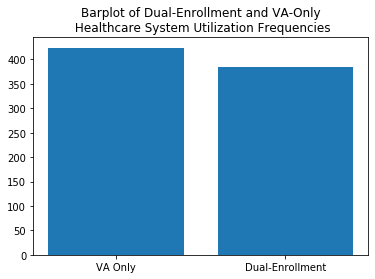

In [41]:
plt.bar(['VA Only', 'Dual-Enrollment'], va_cms_df['Dual Enrollment'].value_counts())
plt.title('Barplot of Dual-Enrollment and VA-Only\n Healthcare System Utilization Frequencies')
#va_cms_df['Dual Enrollment'].hist(bins=2) # or somewhat more "lazily" (lazily meaning simpler but 
                                           # less customizable, not an indictment of any one who 
                                           # using this code as I admitted do usually in EDA!)

### (2) Visualize MME:
First looking separately at the patient populations separately 

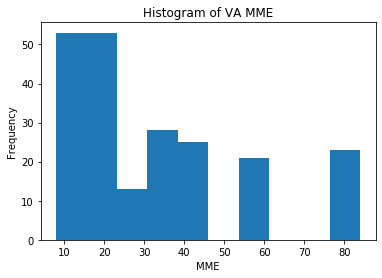

In [42]:
# VA Histogram
va_cms_df.loc[pd.isnull(va_cms_df['Medication CMS']), 'MME VA'].plot.hist()
plt.title('Histogram of VA MME')#.set_color('white')
plt.xlabel('MME')#.set_color('white')
plt.ylabel('Frequency')#.set_color('white')
plt.tick_params(axis='x')#.set_color('white')
plt.tick_params(axis='y')#.set_color('white')

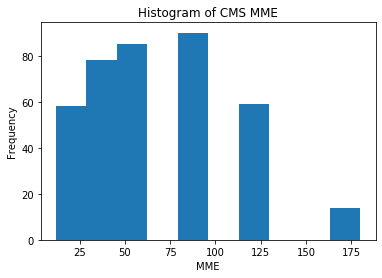

In [43]:
# CMS Histogram
va_cms_df.loc[pd.isnull(va_cms_df['Medication CMS'])==False, 'MME CMS'].plot.hist()
plt.title('Histogram of CMS MME')#.set_color('white')
plt.xlabel('MME')#.set_color('white')
plt.ylabel('Frequency')#.set_color('white')
plt.tick_params(axis='x')#.set_color('white')
plt.tick_params(axis='y')#.set_color('white')

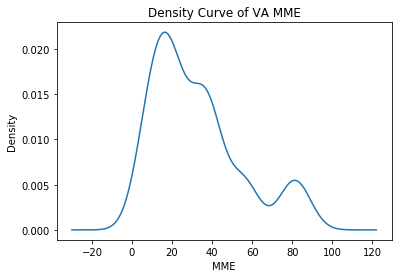

In [44]:
# VA Histogram
va_cms_df.loc[pd.isnull(va_cms_df['Medication CMS']), 'MME VA'].plot.density()
plt.title('Density Curve of VA MME')#.set_color('white')
plt.xlabel('MME')#.set_color('white')
plt.ylabel('Density')#.set_color('white')
plt.tick_params(axis='x')#.set_color('white')
plt.tick_params(axis='y')#.set_color('white')

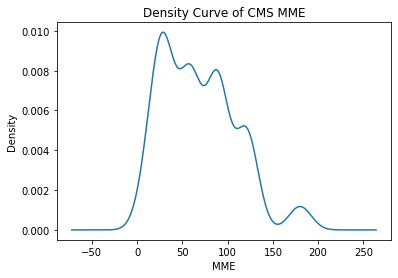

In [45]:
# CMS Density
va_cms_df.loc[pd.isnull(va_cms_df['Medication CMS'])==False, 'MME CMS'].plot.density()
plt.title('Density Curve of CMS MME')#.set_color('white')
plt.xlabel('MME')#.set_color('white')
plt.ylabel('Density')#.set_color('white')
plt.tick_params(axis='x')#.set_color('white')
plt.tick_params(axis='y')#.set_color('white')

Now looking at the dual enrollment patients. Notice I use the `Medication CMS` field to subset these patients, similar to when we looked at CMS patients. Because all observations were VA patients, we can identify dual enrollment patients simply by whether or not they were simultaneously CMS patients. But now rather than look at the CMS only variable `MME CMS`, we look at our summed column `MME Total`. 

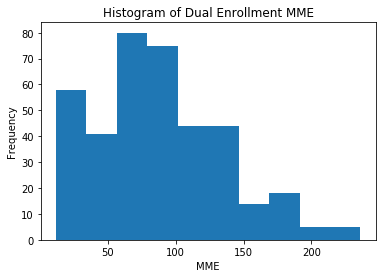

In [46]:
## Dual Enrollment Histogram
va_cms_df.loc[pd.isnull(va_cms_df['Medication CMS'])==False, 'MME Total'].plot.hist()
plt.title('Histogram of Dual Enrollment MME')#.set_color('white')
plt.xlabel('MME')#.set_color('white')
plt.ylabel('Frequency')#.set_color('white')
plt.tick_params(axis='x')#.set_color('white')
plt.tick_params(axis='y')#.set_color('white')

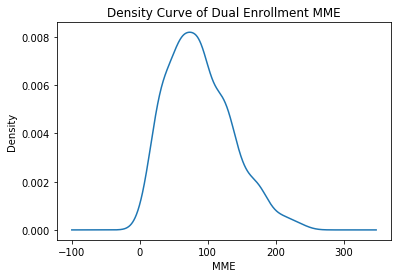

In [47]:
## Dual Enrollment Density Curve
va_cms_df.loc[pd.isnull(va_cms_df['Medication CMS'])==False, 'MME Total'].plot.density()
plt.title('Density Curve of Dual Enrollment MME')#.set_color('white')
plt.xlabel('MME')#.set_color('white')
plt.ylabel('Density')#.set_color('white')
plt.tick_params(axis='x')#.set_color('white')
plt.tick_params(axis='y')#.set_color('white')

### (3) What proportion of dual enrolled patients were prescribed an opioid? Similarly, what proportion of "VA-only" patients?
#### What proportion of dual enrolled patients were prescribed an opioid during both their VA and CMS visits?

In [48]:
# Calculating percentage of VA only patients prescribed an opioid by the VA
num = va_cms_df[(va_cms_df['Opioid VA']==1) & (np.isnan(va_cms_df['Opioid CMS']))].shape[0]
den = va_cms_df[(np.isnan(va_cms_df['Opioid CMS']))].shape[0]
print('Of ', den, ' total "VA-only" patients, ', num, ', (', round(100*num/den, 2) \
      ,'%) were prescribed an opioid by their respective VA hospital.', sep='')

Of 424 total "VA-only" patients, 157, (37.03%) were prescribed an opioid by their respective VA hospital.


In [49]:
# Calculating percentage of CMS only patients prescribed an opioid by their respective CMS institution
num = va_cms_df[(va_cms_df['Opioid CMS']==1) & (np.isnan(va_cms_df['Opioid CMS'])==False)].shape[0]
den = va_cms_df[(np.isnan(va_cms_df['Opioid CMS'])==False)].shape[0]
print('Of ', den, ' total "CMS-only" patients, ', num, ', (', round(100*num/den, 2) \
      ,'%) were prescribed an opioid by their CMS hospital visit.', sep='')

Of 384 total "CMS-only" patients, 196, (51.04%) were prescribed an opioid by their CMS hospital visit.


In [50]:
# Calculating percentage of dual enrolled patients prescribed an opioid from either 
num = va_cms_df[((va_cms_df['Opioid VA']==1) | (va_cms_df['Opioid CMS']==1)) \
               & (np.isnan(va_cms_df['Opioid CMS'])==False)].shape[0]
den = va_cms_df[(np.isnan(va_cms_df['Opioid CMS'])==False)].shape[0]
print('Of ', den, ' total dually-enrolled patients, ', num, ', (', round(100*num/den, 2) \
      ,'%) were prescribed an opioid by either the VA *or* CMS healthcare systems.', sep='')

Of 384 total dually-enrolled patients, 274, (71.35%) were prescribed an opioid by either the VA *or* CMS healthcare systems.


We can modify the immediately above code (looking at the dual-enrollment patients) to  

In [51]:
# Calculating percentage of dual enrolled patients prescribed an opioid from either 
num = va_cms_df[((va_cms_df['Opioid VA']==1) & (va_cms_df['Opioid CMS']==1)) \
               & (np.isnan(va_cms_df['Opioid CMS'])==False)].shape[0]
den = va_cms_df[(np.isnan(va_cms_df['Opioid CMS'])==False)].shape[0]
print('Of ', den, ' total dually-enrolled patients, ', num, ', (', round(100*num/den, 2) \
      ,'%) were prescribed an opioid by the VA *and* CMS healthcare systems.', sep='')

Of 384 total dually-enrolled patients, 79, (20.57%) were prescribed an opioid by the VA *and* CMS healthcare systems.


### (4) Create an illustrative visualization
This step is left open-ended, such that you can visualize the differences in opioid prescription how you feel is most effective. We could simply plot a bar graph of the proportion of opioid prescription by type of patient, comparing VA-only to dual-enrollment:

Text(0.5, 1.0, 'Proportion of Opioid Prescription by Dual Enrollment Status')

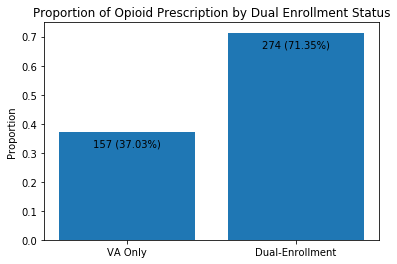

In [60]:
dual_tot_num = va_cms_df[(
                         (va_cms_df['Opioid VA']==1) | (va_cms_df['Opioid CMS']==1)
                         )  &
                         (np.isnan(va_cms_df['Opioid CMS'])==False) ].shape[0]
dual_tot_den =  va_cms_df[np.isnan(va_cms_df['Opioid CMS'])==False].shape[0]

va_tot_num = va_cms_df[(
                        (va_cms_df['Opioid VA']==1) &
                        (np.isnan(va_cms_df['Opioid CMS']))
                       )].shape[0]
va_tot_den = va_cms_df[np.isnan(va_cms_df['Opioid CMS'])].shape[0]

plt.bar(['VA Only', 'Dual-Enrollment'], 
        [va_tot_num / va_tot_den,
         dual_tot_num / dual_tot_den])
plt.annotate(str(va_tot_num) + ' (' + str(round(100*va_tot_num / va_tot_den, 2)) + '%)',
             [-0.2, (va_tot_num / va_tot_den)-0.05])
plt.annotate(str(dual_tot_num) + ' (' + str(round(100*dual_tot_num / dual_tot_den, 2)) + '%)',
             [0.8, (dual_tot_num / dual_tot_den)-0.05])
plt.ylabel('Proportion')
plt.title('Proportion of Opioid Prescription by Dual Enrollment Status')

We could build upon the previous graph by bringing in CMS patients and examining among CMS patients the proportion of CMS-only opioid prescription prevalence as well:

Text(0.5, 1.0, 'Proportion of Opioid Prescription\n Stratified by Healthcare System Utilization')

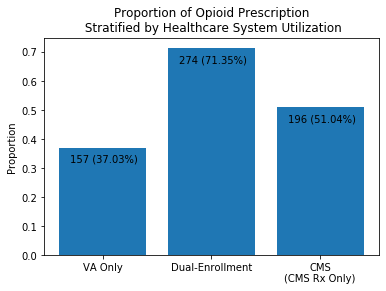

In [61]:
dual_tot_num = va_cms_df[(
                         (va_cms_df['Opioid VA']==1) | (va_cms_df['Opioid CMS']==1)
                         )  &
                         (np.isnan(va_cms_df['Opioid CMS'])==False) ].shape[0]
dual_tot_den =  va_cms_df[np.isnan(va_cms_df['Opioid CMS'])==False].shape[0]

va_tot_num = va_cms_df[(
                        (va_cms_df['Opioid VA']==1) &
                        (np.isnan(va_cms_df['Opioid CMS']))
                       )].shape[0]
va_tot_den = va_cms_df[np.isnan(va_cms_df['Opioid CMS'])].shape[0]

cms_only_num = va_cms_df[(
                        (va_cms_df['Opioid CMS']==1) &
                        (np.isnan(va_cms_df['Opioid CMS'])==False)
                       )].shape[0]
cms_only_den = va_cms_df[np.isnan(va_cms_df['Opioid CMS'])==False].shape[0]


plt.bar(['VA Only', 'Dual-Enrollment', 'CMS\n(CMS Rx Only)'], 
        [va_tot_num / va_tot_den,
        dual_tot_num / dual_tot_den,
        cms_only_num / cms_only_den])
plt.annotate(str(va_tot_num) + ' (' + str(round(100*va_tot_num / va_tot_den, 2)) + '%)',
             [-0.3, (va_tot_num / va_tot_den)-0.05])
plt.annotate(str(dual_tot_num) + ' (' + str(round(100*dual_tot_num / dual_tot_den, 2)) + '%)',
             [0.7, (dual_tot_num / dual_tot_den)-0.05])
plt.annotate(str(cms_only_num) + ' (' + str(round(100*cms_only_num / cms_only_den, 2)) + '%)',
             [1.7, (cms_only_num / cms_only_den)-0.05])
plt.ylabel('Proportion')
plt.title('Proportion of Opioid Prescription\n Stratified by Healthcare System Utilization')

### Bonus Visualization - Shade Filling

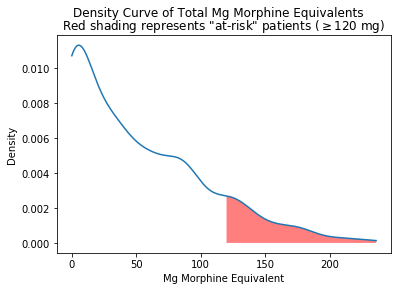

In [65]:
from scipy.stats import gaussian_kde

density_dual = gaussian_kde(va_cms_df['MME Total'])
density_dual.covariance_factor = lambda : .25 
density_dual._compute_covariance()

x_plot = np.linspace(min(va_cms_df['MME Total']), max(va_cms_df['MME Total']), 200)
y_plot = density_dual(x_plot)
plt.plot(x_plot, y_plot)
plt.suptitle('Density Curve of Total Mg Morphine Equivalents')
plt.title('Red shading represents "at-risk" patients ($\geq120$ mg)')
plt.ylabel('Density')
plt.xlabel('Mg Morphine Equivalent')
if max(va_cms_df['MME Total'])>=120:
    x_fill = np.linspace(120, max(va_cms_df['MME Total']) , 200)
    y_fill = density_dual(x_fill)
    plt.fill_between(x_fill, y_fill, facecolor='r', alpha=0.5)


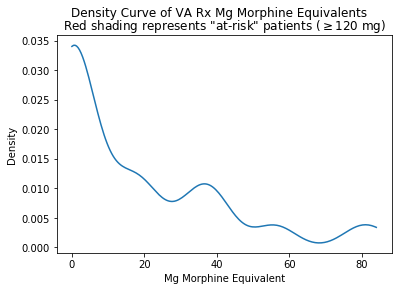

In [67]:
va_mme_v = np.where(np.isnan(va_cms_df['MME VA'])==False, va_cms_df['MME VA'], 0)

density_va = gaussian_kde(va_mme_v)
density_va.covariance_factor = lambda : .25 
density_va._compute_covariance()

x_plot = np.linspace(min(va_mme_v), max(va_mme_v), 200)
y_plot = density_va(x_plot)
plt.plot(x_plot, y_plot)
plt.suptitle('Density Curve of VA Rx Mg Morphine Equivalents')
plt.title('Red shading represents "at-risk" patients ($\geq120$ mg)')
plt.ylabel('Density')
plt.xlabel('Mg Morphine Equivalent')

if max(va_mme_v)>=120:
    x_fill = np.linspace(120, max(va_mme_v) , 200)
    y_fill = density_va(x_fill)
    plt.fill_between(x_fill, y_fill, facecolor='r', alpha=0.5)


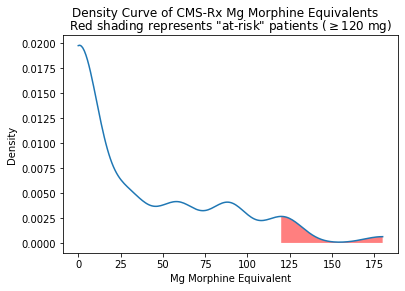

In [68]:
cms_mme_v = np.where(np.isnan(va_cms_df['MME CMS'])==False, va_cms_df['MME CMS'], 0)

density_cms = gaussian_kde(cms_mme_v)
density_cms.covariance_factor = lambda : .25 
density_cms._compute_covariance()

x_plot = np.linspace(min(cms_mme_v), max(cms_mme_v), 200)
y_plot = density_cms(x_plot)
plt.plot(x_plot, y_plot)
plt.suptitle('Density Curve of CMS-Rx Mg Morphine Equivalents')
plt.title('Red shading represents "at-risk" patients ($\geq120$ mg)')
plt.ylabel('Density')
plt.xlabel('Mg Morphine Equivalent')

if max(cms_mme_v)>=120:
    x_fill = np.linspace(120, max(cms_mme_v) , 200)
    y_fill = density_cms(x_fill)
    plt.fill_between(x_fill, y_fill, facecolor='r', alpha=0.5)
